In [1]:
import pandas as pd
import numpy as np
import os

# import tensorflow

In [2]:
ls = os.listdir("/Volumes/tim_details/tim_honours/CAPTURES/client_pi_50")
ls.sort()
ls

['v=3InbMow9IYo',
 'v=A3gUpodXMv0',
 'v=NSW5u1RTxEA',
 'v=gxxqdrrpgZc',
 'v=mkWKZWMokdI',
 'v=t634q_Voeto',
 'v=t6jlhqNxRYk',
 'v=w_oGIbFjiCo',
 'v=yve6qo6eowU']

In [19]:
# LOADING IN DATA
# NOTE: combining data in different steps to reduce the load of np.concatenate

classes = [
    "client_pc_50",
    "client_pc_200",
    "client_pc_200_wall",
    "client_pi_50",
    "client_pi_200",
    "client_pi_200_wall"
]
inner_dirs = [
    'v=3InbMow9IYo',
    # "v=A3gUpodXMv0",
    # "v=NSW5u1RTxEA",
    # "v=gxxqdrrpgZc",
    # "v=mkWKZWMokdI",
    # "v=t634q_Voeto",
    # "v=t6jlhqNxRYk",
    # "v=w_oGIbFjiCo",
    # "v=yve6qo6eowU"
]
dir = "/Volumes/tim_details/tim_honours/CAPTURES/"

# Init total X and y arrays
X = np.zeros((0,500,64))
y = np.zeros((0))
# Iterating through all the dev, loc classes
for c in classes:
    # Getting dev, loc dir
    dir_c = os.path.join(dir, c)
    # Init dev, loc X and y arrays
    X_c = np.zeros((0,500,64))
    y_c = np.zeros((0))
    # Iterating through all the vid classes
    for i in inner_dirs:
        print(c, i)
        # Getting dev, loc, vid dir and csi fp
        dir_c_i = os.path.join(dir_c, i)
        csi_fp = os.path.join(dir_c_i, "csi_all.npy")
        # Loading in csi npy file
        X_c_i = np.load(csi_fp)
        y_c_i = np.repeat(c, X_c_i.shape[0])
        # Trimming data (reduced computation)
        X_c_i = X_c_i[:, 2000:2500, :]
        # Combining vid data into dev, loc X and y arrays
        X_c = np.concatenate([X_c, X_c_i], axis=0)
        y_c = np.concatenate([y_c, y_c_i], axis=0)
    # Combining dev, loc data into total X and y arrays
    X = np.concatenate([X, X_c], axis=0)
    y = np.concatenate([y, y_c], axis=0)
    print()


client_pc_50 v=3InbMow9IYo

client_pc_200 v=3InbMow9IYo

client_pc_200_wall v=3InbMow9IYo

client_pi_50 v=3InbMow9IYo

client_pi_200 v=3InbMow9IYo

client_pi_200_wall v=3InbMow9IYo



In [22]:
# CLEANING DATA

# REMOVING CAPTURES WITH LESS THAN X FRAMES
# Getting whether any frame (all subc in the frame) are non-zero (thus valid frame)
# then finding the number of valid frames for each capture.
# If the number of valid frames is below thresh, then it is an invalid capture (deleted)
thresh = 400
samples_to_remove = np.any(X != 0, axis=2).sum(axis=1) < thresh
# Filtering out invalid frames
X_cleaned = np.delete(X, samples_to_remove, axis=0)
y_cleaned = np.delete(y, samples_to_remove, axis=0)

# Filtering out null and pilot frames
nulls = [0, 1, 2, 3, 4, 5, 63, 62, 61, 60, 59, 32]
pilots = [11, 25, 53, 39]
null_pilots = np.concatenate([nulls, pilots])
X_cleaned = np.delete(X_cleaned, null_pilots, axis=2)

print(X_cleaned.shape)

(581, 500, 48)


In [23]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# Encode the labels
# le = LabelEncoder()
lb = LabelBinarizer()
lb.fit(y_cleaned)
y_lb = lb.transform(y_cleaned)

In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

# Converting the complex numbers to an array of 2D arrays with specified channels
X_procd = np.zeros((*X_cleaned.shape, 0))

# Amplitude channel
X_amp = X_cleaned
X_amp = np.abs(X_amp) / np.abs(X_amp).max()
X_amp = np.log1p(X_amp)
X_amp = X_amp.reshape(*X_amp.shape, 1)
X_procd = np.concatenate([X_procd, X_amp], axis=3)

# Phase channel
# X_phase = X_cleaned
# X_phase = np.angle(X_phase) / (2*np.pi) + 0.5
# X_phase = X_procd.reshape(*X_phase.shape, 1)
# X_procd = np.concatenate([X_procd, X_phase], axis=3)

X_procd.shape

(581, 500, 48, 1)

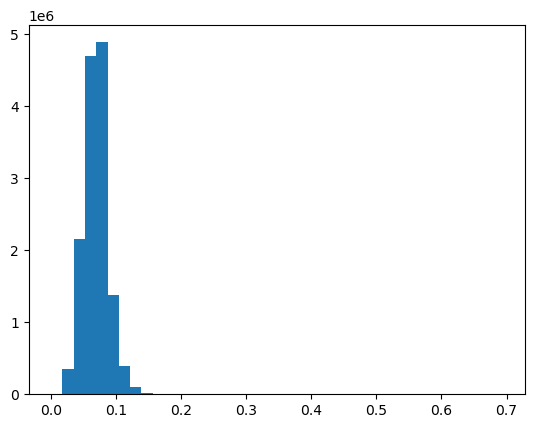

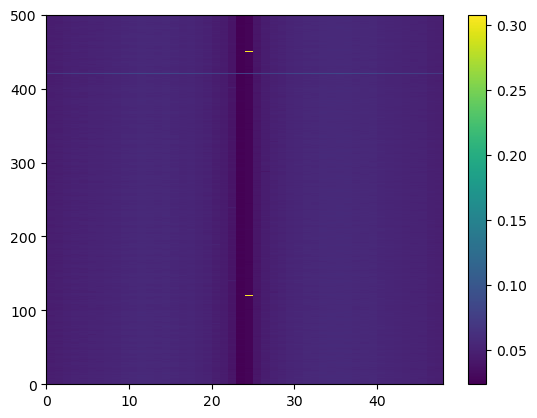

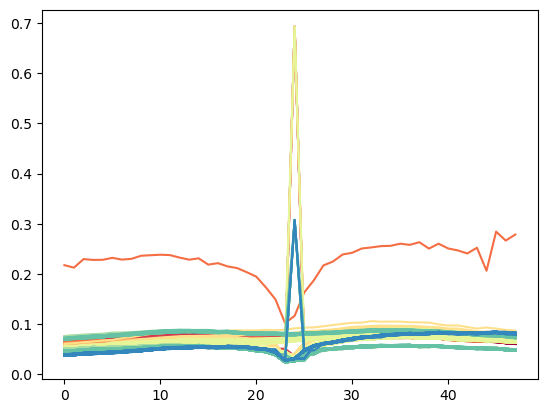

In [38]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Showing distribution of all csi amplitude values
plt.hist(
    # x_procd[y_cleaned=="client_pc_200"].flatten(),
    X_procd.flatten(),
    bins=40,
    )
plt.show()

# SENSE CHECKING EXAMPLE CSI HEATMAP IMAGE
im = plt.pcolormesh(
    np.abs(X_procd[198, :, :, 0]),
)
plt.colorbar(im)
plt.show()

my_col = colormaps['Spectral']
for i in np.arange(180, 190):
    plt.plot(
        np.abs(X_procd[i, :, :, 0]).T,
        color=my_col((i-180)/10),
        alpha=1
    )
plt.show()

In [39]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_procd,
    y_lb,
    test_size=0.2,
    random_state=42,
    stratify=y_lb,
)

# Flattening this data (reshaping) to feed into different ML algos
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [40]:
print(X_train.shape)
print(X_train_flat.shape)

(464, 500, 48, 1)
(464, 24000)


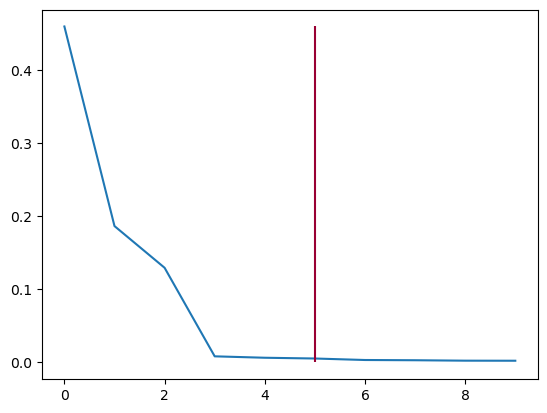

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PERFORMING PCA ANALYSIS (IN-CASE)
# Initialize and fit the PCA model
pca = PCA(n_components=10)
pca.fit(np.abs(X_train_flat))

# Transform the data to the lower-dimensional space (and selecting only the top 3 components)
n_components = 5
X_train_pca = pca.transform(np.abs(X_train_flat))[:, :n_components]
X_test_pca = pca.transform(np.abs(X_test_flat))[:, :n_components]

plt.plot(pca.explained_variance_ratio_)
plt.vlines(x=n_components, ymin=0, ymax=pca.explained_variance_ratio_.max(), colors=(0.6,0,0.2))
plt.show()

In [42]:
# KNN WORKS VERY WELL!! Fast with PCA.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making KNN
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None
)

# Training KNN
# knn.fit(X_train_flat, y_train)
knn.fit(X_train_pca, y_train)

# Evaluating KNN
# y_pred = knn.predict(X_test_flat)
y_pred = knn.predict(X_test_pca)

# Showing evaluation confusion matrix
cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test),
) # cols = actual, rows = predicted
print(cm)
print(classification_report(y_test, y_pred, target_names=classes))
print(accuracy_score(y_test, y_pred))


[[19  1  2  0  0  0]
 [ 0 18  0  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  0 18  0  0]
 [ 0  0  0  1 20  0]
 [ 0  0  0  1  0 20]]
                    precision    recall  f1-score   support

      client_pc_50       0.86      1.00      0.93        19
     client_pc_200       1.00      0.95      0.97        19
client_pc_200_wall       1.00      0.89      0.94        19
      client_pi_50       1.00      0.90      0.95        20
     client_pi_200       0.95      1.00      0.98        20
client_pi_200_wall       0.95      1.00      0.98        20

         micro avg       0.96      0.96      0.96       117
         macro avg       0.96      0.96      0.96       117
      weighted avg       0.96      0.96      0.96       117
       samples avg       0.96      0.96      0.96       117

0.9572649572649573


In [43]:
# SVM classifier with RBF. Not as fast or accurate as KNN
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making RBF SVM
svc = SVC(
    C=2.0, # Regularisation parameter. Reg strength is inversely proportional to C
    kernel='rbf', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable
    # degree=3, # Degree for poly kernels
    gamma='scale', # {‘scale’, ‘auto’} or float
    coef0=0.0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
    shrinking=True, # Whether to use the shrinking heuristic
    probability=False, # Allows predict_proba but slows down process
    tol=0.001, # Tolerance for stopping criterion.
    cache_size=200, # Specify the size of the kernel cache in MB
    class_weight=None, # Set the parameter C of class i to class_weight[i]*C. Keep as none for equal weights across classes
    verbose=False, # Enable verbose output
    max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit
    decision_function_shape='ovo', # {‘ovo’, ‘ovr’}
    break_ties=False,
    random_state=None
)
svc_mc = OneVsRestClassifier(svc)

# Training KNN
# svc_mc.fit(X_train_flat, y_train)
svc_mc.fit(X_train_pca, y_train)

# Evaluating KNN
# y_pred = svc_mc.predict(X_test_flat)
y_pred = svc_mc.predict(X_test_pca)

# Showing evaluation confusion matrix
cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test),
)
print(cm)
print(classification_report(y_test, y_pred, target_names=classes))
print(accuracy_score(y_test, y_pred))

[[19  1  2  2  0  0]
 [ 0 18  0  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  0 16  1  0]
 [ 0  0  0  0 19  2]
 [ 0  0  0  2  0 18]]
                    precision    recall  f1-score   support

      client_pc_50       0.90      1.00      0.95        19
     client_pc_200       1.00      0.95      0.97        19
client_pc_200_wall       1.00      0.89      0.94        19
      client_pi_50       0.94      0.80      0.86        20
     client_pi_200       0.86      0.95      0.90        20
client_pi_200_wall       0.91      1.00      0.95        20

         micro avg       0.93      0.93      0.93       117
         macro avg       0.94      0.93      0.93       117
      weighted avg       0.94      0.93      0.93       117
       samples avg       0.92      0.93      0.92       117

0.905982905982906


/Users/timothylee/miniconda3/envs/honours_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making MLP model with Entire CSI matrix.
model = tf.keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(16, (10, 24), (5, 2), padding="valid", activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), 2, padding="valid", activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(lb.classes_), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
    ],
)

# Show model architecture
model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    verbose=True,
)

# Evaluating the model
y_pred = model.predict(X_test)
y_pred = tf.keras.utils.to_categorical(y_pred.argmax(axis=1), len(lb.classes_)).astype(int)

cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test)
)
print(cm)
print(classification_report(y_test, y_pred, target_names=classes))
print(accuracy_score(y_test, y_pred))

4/4 [==============================] - 0s 5ms/step
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [19 19 19 20 20 20]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
                    precision    recall  f1-score   support

      client_pc_50       0.00      0.00      0.00        19
     client_pc_200       0.00      0.00      0.00        19
client_pc_200_wall       0.16      1.00      0.28        19
      client_pi_50       0.00      0.00      0.00        20
     client_pi_200       0.00      0.00      0.00        20
client_pi_200_wall       0.00      0.00      0.00        20

         micro avg       0.16      0.16      0.16       117
         macro avg       0.03      0.17      0.05       117
      weighted avg       0.03      0.16      0.05       117
       samples avg       0.16      0.16      0.16       117

0.1623931623931624


/Users/timothylee/miniconda3/envs/honours_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making MLP model with PCA
model = tf.keras.Sequential([
    layers.Input(shape=X_train_pca.shape[1:]),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(lb.classes_), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        # tf.keras.metrics.Accuracy(),
        tf.keras.metrics.CategoricalAccuracy(),
    ],
)

# Show model architecture
# model.summary()

# Training the model
history = model.fit(
    X_train_pca,
    y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    verbose=True,
)

# Evaluating the model
y_pred = model.predict(X_train_pca)
y_pred = tf.keras.utils.to_categorical(y_pred.argmax(axis=1), len(lb.classes_)).astype(int)

cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_train)
)
print(cm)
print(classification_report(y_train, y_pred, target_names=classes))
print(accuracy_score(y_train, y_pred))

Epoch 1/10
24/24 [==============================] - 1s 8ms/step - loss: 1.1495 - categorical_accuracy: 0.5499 - val_loss: 0.6232 - val_categorical_accuracy: 0.7849
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.5334 - categorical_accuracy: 0.7925 - val_loss: 0.3928 - val_categorical_accuracy: 0.8280
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.4473 - categorical_accuracy: 0.8410 - val_loss: 0.2769 - val_categorical_accuracy: 0.8925
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.3661 - categorical_accuracy: 0.8733 - val_loss: 0.2396 - val_categorical_accuracy: 0.9247
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2821 - categorical_accuracy: 0.9137 - val_loss: 0.2514 - val_categorical_accuracy: 0.8925
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2654 - categorical_accuracy: 0.9030 - val_loss: 0.2075 - val_categorical_accuracy: 0.9462
Epoch 7/10
24/24

In [73]:
# Evaluating the model
y_pred = model.predict(X_test_pca)
y_pred = tf.keras.utils.to_categorical(y_pred.argmax(axis=1), len(lb.classes_)).astype(int)

cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test)
)
print(cm)
print(classification_report(y_test, y_pred, target_names=classes))
print(accuracy_score(y_test, y_pred))

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step
[[17  0  1  0  0  0]
 [ 0 19  0  0  0  0]
 [ 2  0 18  0  0  0]
 [ 0  0  0 18  1  0]
 [ 0  0  0  1 19  2]
 [ 0  0  0  1  0 18]]
                    precision    recall  f1-score   support

      client_pc_50       0.94      0.89      0.92        19
     client_pc_200       1.00      1.00      1.00        19
client_pc_200_wall       0.90      0.95      0.92        19
      client_pi_50       0.95      0.90      0.92        20
     client_pi_200       0.86      0.95      0.90        20
client_pi_200_wall       0.95      0.90      0.92        20

         micro avg       0.93      0.93      0.93       117
         macro avg       0.93      0.93      0.93       117
      weighted avg       0.93      0.93      0.93       117
       samples avg       0.93      0.93      0.93       117

0.9316239316239316
